导入相关包

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import params
import utils
#自定义处理方法
import processor


%matplotlib inline


Using TensorFlow backend.


### 探索数据集

查看视频文件

In [ ]:
cap = cv2.VideoCapture(processor.get_front_file(1))
ret, frame = cap.read()
cap.release()
plt.imshow(frame)
#shape
print('shape:')
frame.shape

查看转向数据文件

In [3]:
wheel01 = utils.fetch_csv_data(processor.get_steering_file(1))
wheel01.head(10)

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0
5,1464650070452581,5,-1.0
6,1464650070485914,6,-1.0
7,1464650070519247,7,-1.0
8,1464650070552581,8,-1.0
9,1464650070585914,9,-1.5


查看合并数据集

Records in epoch01_steering.csv : 1500
Records in epoch02_steering.csv : 3900
Records in epoch03_steering.csv : 2700
Records in epoch04_steering.csv : 2700
Records in epoch05_steering.csv : 2700
Records in epoch06_steering.csv : 2700
Records in epoch07_steering.csv : 2700
Records in epoch08_steering.csv : 2700
Records in epoch09_steering.csv : 2700
Records in epoch10_steering.csv : 2700
Total records from epoch01 to epoch10 : 27000


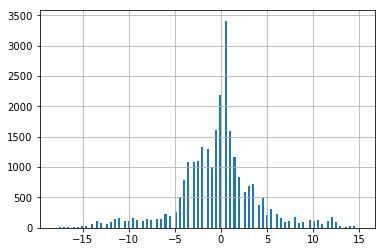

In [4]:
processor.check_dataset(1,10)

读取图片

Records in epoch01_steering.csv : 1500
Wheel of frame 1173 : 4.5


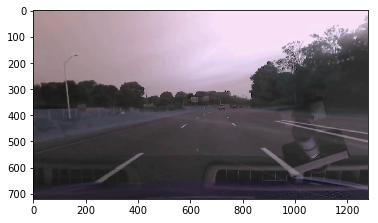

In [5]:
def show_img(img):
    plt.imshow(img)
    plt.show()
    
# load
sample_img = utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
epoch1 = processor.get_combine_dataset(1,1)
sample_sig = epoch1[1173]
print('Wheel of frame 1173 : '+str(sample_sig))
#show
show_img(sample_img)

改变色域

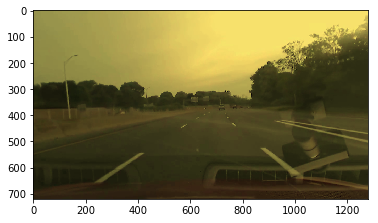

In [6]:
sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=processor.change_color_space(sample_img)
show_img(sample_img)

平移图像

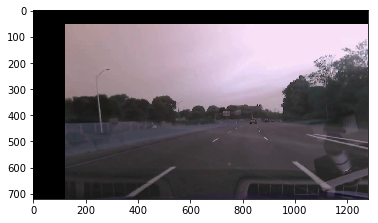

In [7]:
sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=processor.translate(sample_img)
show_img(sample_img)

缩放图像

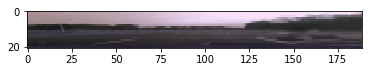

In [8]:
sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=processor.resize(sample_img)
show_img(sample_img)

### Checkpoint is here

In [1]:
import processor
import params
import numpy as np

Using TensorFlow backend.


分批读取数据集

In [3]:
all_features,all_labels = processor.load_dataset(need_ori=True)

Start to load datasets...
Processing epoch01>>>
Frames in features01.p : 3000
Records in labels01.p : 3000
Processing epoch02>>>
Frames in features02.p : 7800
Records in labels02.p : 7800
Processing epoch03>>>
Frames in features03.p : 5400
Records in labels03.p : 5400
Processing epoch04>>>
Frames in features04.p : 5400
Records in labels04.p : 5400
Processing epoch05>>>
Frames in features05.p : 5400
Records in labels05.p : 5400
Processing epoch06>>>
Frames in features06.p : 5400
Records in labels06.p : 5400
Processing epoch07>>>
Frames in features07.p : 5400
Records in labels07.p : 5400
Processing epoch08>>>
Frames in features08.p : 5400
Records in labels08.p : 5400
Processing epoch09>>>
Frames in features09.p : 5400
Records in labels09.p : 5400
Done
Length of features : 48600, length of labels : 48600


引入keras相关包

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten
from keras import optimizers

In [4]:
def get_nvidia_model():
    print("Start to create model")
    model = Sequential()
    model.add(Lambda(lambda x:x/255., input_shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c)))
    model.add(Convolution2D(24,(5,5), activation='relu', strides=(2,2), padding='valid'))
    model.add(Convolution2D(36,(5,5), activation='relu', strides=(2,2), padding='valid'))
    model.add(Convolution2D(48,(5,5), activation='relu', strides=(2,2), padding='valid'))
    model.add(Convolution2D(64,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Convolution2D(64,(3,3), activation='relu', strides=(1,1), padding='valid'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mse', optimizer='Adam')
    print("Model created")
    return model


In [5]:
model = get_nvidia_model()
#fitted_model = processor.fit_model(all_features,all_labels,model)

Start to create model
Model created


In [6]:
processor.display_fit_result(fitted_model)

NameError: name 'fitted_model' is not defined

修改模型

In [3]:
from keras.layers.pooling import MaxPooling2D 
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

def get_nvidia_model_2():
    print("Start to create model")
    model = Sequential()
    model.add(Lambda(lambda x:x/255., input_shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c)))
    
    model.add(Convolution2D(24,(3,3), activation='elu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(32,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(48,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(1164, activation='elu'))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    adam = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=adam)
    print("Model created")
    return model


Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(38880, 64, 64, 3) (38880, 1)
Shape of test set
(9720, 64, 64, 3) (9720, 1)
Start training
Train on 31104 samples, validate on 7776 samples
Epoch 1/35
31104/31104 [==============================] - 295s - loss: 19.6255 - val_loss: 21.7737
Epoch 2/35
31104/31104 [==============================] - 278s - loss: 16.6023 - val_loss: 24.4736
Epoch 3/35
31104/31104 [==============================] - 278s - loss: 14.2783 - val_loss: 23.0155
Epoch 4/35
31104/31104 [==============================] - 279s - loss: 13.0787 - val_loss: 16.5218
Epoch 5/35
31104/31104 [==============================] - 278s - loss: 12.3935 - val_loss: 16.8963
Epoch 6/35
31104/31104 [==============================] - 279s - loss: 11.7312 - val_loss: 13.0954
Epoch 7/35
31104/31104 [==============================] - 279s - loss: 11.1168 - val_loss: 12.8670
Epoch 8/35
31104/31104 [======

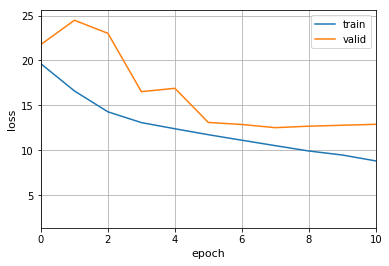

In [6]:
model = get_nvidia_model_2()
fitted_model = processor.fit_model(all_features,all_labels,model,epochs=35)
processor.display_fit_result(fitted_model)

In [10]:
import utils
json_string = model.to_json()
open(utils.join_dir(params.model_dir,"model.json"),'w').write(json_string) 
model.save_weights(utils.join_dir(params.model_dir,"model.h5"))
print("Model and weights already saved")

Model and weights already saved


In [1]:
import run

Using TensorFlow backend.


Model already exists, do you want to reuse? (y/n): y
Model fetched from the disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 24)        672       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 24)        96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        6944      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_____________________________________________________________

Start to create model
Model created
Frames in features10.p : 2700
Records in labels10.p : 2700
2700/2700 [==============================] - 9s     
Test loss is:8.714785423808628


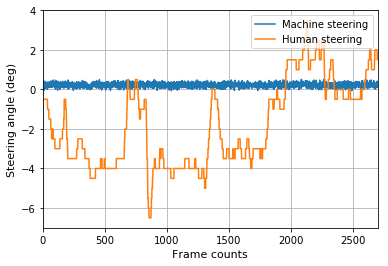

In [8]:
import utils
import matplotlib.pyplot as plt

model = get_nvidia_model_2()
features_file = utils.join_dir(params.pickle_dir,'features10.p')
labels_file = utils.join_dir(params.pickle_dir,'labels10.p')
        
features = processor.load_features(features_file,10)
labels = processor.load_labels(labels_file,10)

features = np.array(features)
labels = np.array(labels)
labels = np.reshape(labels,(len(labels),1))
    
    
loss= model.evaluate(features, labels, batch_size=256, verbose=1)
print('Test loss is:{}'.format(loss))


maching_labels = model.predict(features, batch_size=128, verbose=0)

human_lanels=labels

plt.figure
plt.plot(maching_labels)
plt.plot(labels)
plt.ylabel('Steering angle (deg)', fontsize=11)
plt.xlabel('Frame counts', fontsize=11)
plt.legend(['Machine steering', 'Human steering'], loc='upper right')
plt.xlim((0,2700))
#plt.xticks(np.arange(0, 21, 5))
plt.grid()
#plt.savefig(img_dir + "/result.png", dpi=300)
plt.show()